In [48]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, datasets, Sequential, regularizers

print('python version:', sys.version.split('\n')[0])
for m in [tf, np, pd, mpl, sns]:
    print(m.__name__, 'version:', m.__version__)

python version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
tensorflow version: 2.3.1
numpy version: 1.18.5
pandas version: 1.1.3
matplotlib version: 3.3.2
seaborn version: 0.11.0


In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

In [8]:
def load_dataset():
    N_SAMPLES = 1000
    TEST_SIZE = None
    X , y =make_moons(n_samples=N_SAMPLES, noise=0.25, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state=0)
    return X, y, X_train, X_test, y_train, y_test

In [16]:
def make_plot(X, y, plot_name, XX=None, YY=None, preds=None):

    axes = plt.gca()
    axes.set_xlim([-2, 3])
    axes.set_ylim([-1.5, 2])
    axes.set(xlabel="$x_1$", ylabel="$x_2$")
    plt.title(plot_name, fontsize=20, fontproperties='SimHei')
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if XX is not None and YY is not None and preds is not None:
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha=0.08, cmap=plt.cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)

    markers = ['o' if i == 1 else 's' for i in y.ravel()]
    mscatter(X[:, 0], X[:, 1], c=y.ravel(), s=20, cmap=plt.cm.Spectral, edgecolors='none', m=markers, ax=axes)
    plt.show()

In [11]:
def mscatter(x, y, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax = plt.gca()
    sc = ax.scatter(x, y, **kw)
    if (m is not None) and (len(m) == len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [28]:
def network_laysers_influence(X_train,y_train):
    for n in range(5):
        model = Sequential()
        model.add(layers.Dense(8, input_dim=2, activation='relu'))
        for _ in range(n):
            model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=500, verbose=0)
        xx = np.arange(-2, 3, 0.01)
        yy = np.arange(-1.5, 2, 0.01)
        
        XX,YY = np.meshgrid(xx, yy)
        
        preds = model.predict_classes(np.c_[XX.ravel(), YY.ravel()])
        title = "Layers: {0}".format(2 + n)
        make_plot(X_train, y_train, title, XX, YY, preds)

In [41]:
def dropout_influence(X_train, y_train):
    for n in range(5):
        model = Sequential()
        model.add(layers.Dense(8, input_dim=2, activation='relu'))
        counter = 0
        for h in range(5):
            model.add(layers.Dense(64, input_dim=2, activation='relu'))
            if counter < n:
                counter += 1
                model.add(layers.Dropout(rate=0.5))
            model.add(layers.Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=500, verbose=0)
            
            xx = np.arange(-2,3,0.01)
            yy = np.arange(-1.5,2,0.01)
            
            XX, YY = np.meshgrid(xx, yy)
            preds = model.predict_classes(np.c_[XX.ravel(), YY.ravel()])
            title = "{0} hiden layer".format(h+1) if n == 0 else "{0} hiden layer ".format(h+1)+"{0}Dropout layer".format(n)
            make_plot(X_train, y_train, title,  XX, YY, preds)


In [44]:
def build_model_with_regularization(_lambda):

    model = Sequential()
    model.add(layers.Dense(8, input_dim=2, activation='relu'))  # 不带正则化项

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(_lambda)))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(_lambda)))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(_lambda)))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # 模型装配
    return model

In [58]:
def plot_weights_matrix(model, layer_index, plot_name, file_name):

    weights = model.layers[layer_index].get_weights()[0]
    shape = weights.shape

    X = np.array(range(shape[1]))
    Y = np.array(range(shape[0]))
    X, Y = np.meshgrid(X, Y)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    plt.title(plot_name, fontsize=20, fontproperties='SimHei')

    ax.plot_surface(X, Y, weights, cmap=plt.get_cmap('rainbow'), linewidth=0)

    ax.set_xlabel('x', fontsize=16, rotation=0, fontproperties='SimHei')
    ax.set_ylabel('y', fontsize=16, rotation=0, fontproperties='SimHei')
    ax.set_zlabel('weights', fontsize=16, rotation=90, fontproperties='SimHei')

    plt.show()

In [60]:
def regularizers_influence(X_train, y_train):
    for _lambda in [1e-5, 1e-3, 1e-1, 0.12, 0.13]:

        model = build_model_with_regularization(_lambda)
        model.fit(X_train, y_train, epochs=500, verbose=0)

        layer_index = 2
        plot_title = "regularrizer: {}".format(_lambda)
        file_name = "weights_" + str(_lambda)
        plot_weights_matrix(model, layer_index, plot_title, file_name)

        xx = np.arange(-2, 3, 0.01)
        yy = np.arange(-1.5, 2, 0.01)
        XX, YY = np.meshgrid(xx, yy)
        
        preds = model.predict_classes(np.c_[XX.ravel(), YY.ravel()])
        title = "regularrizer: {}".format(_lambda)
        make_plot(X_train, y_train, title, XX, YY, preds)

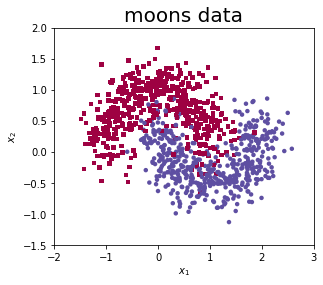

In [25]:
X, y, X_train, X_test, y_train, y_test = load_dataset()
make_plot(X, y, "moons data")

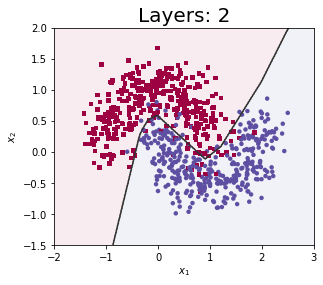

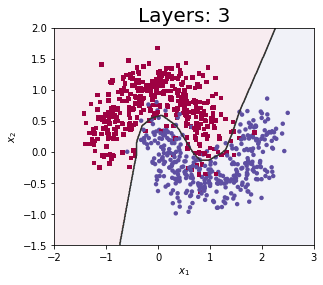

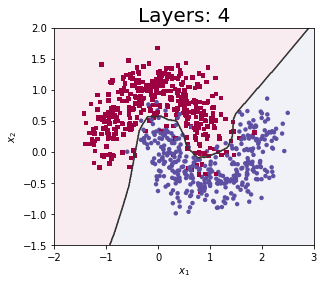

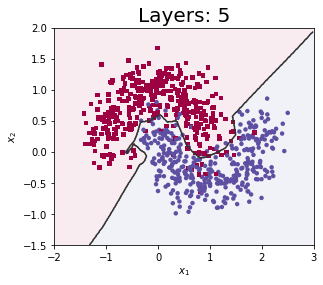

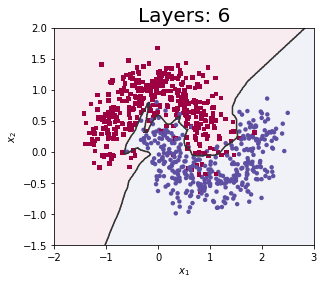

In [29]:
network_laysers_influence(X_train,y_train)

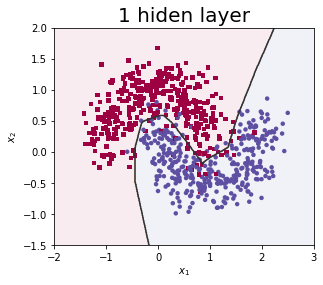

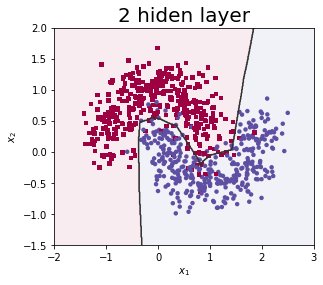

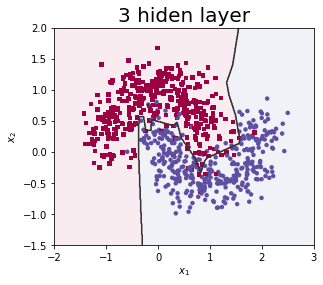

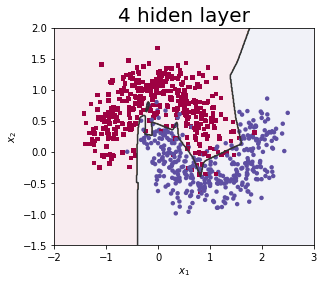

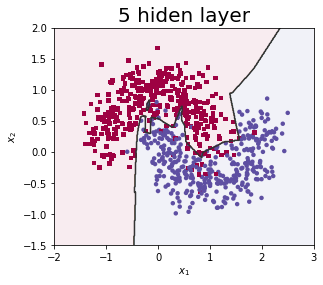

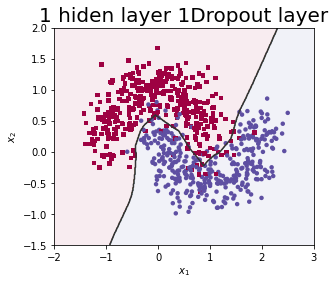

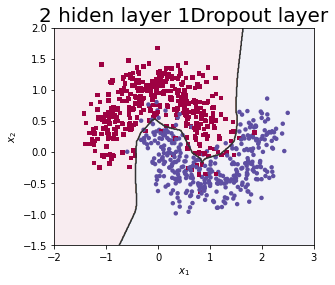

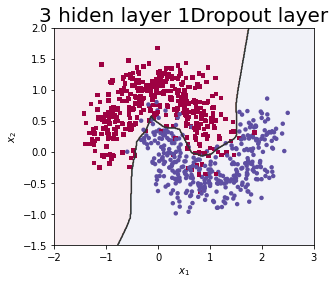

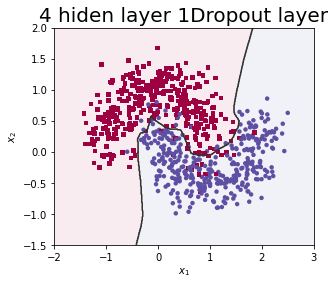

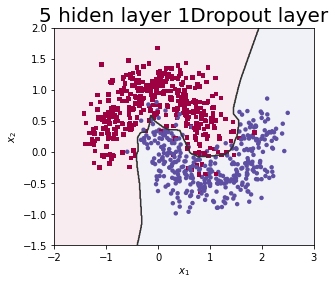

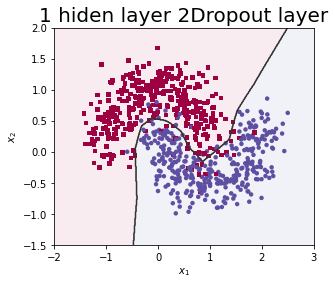

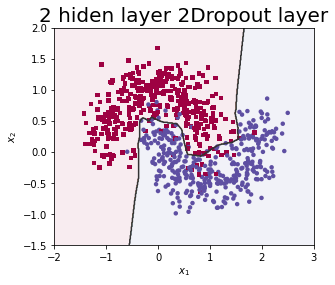

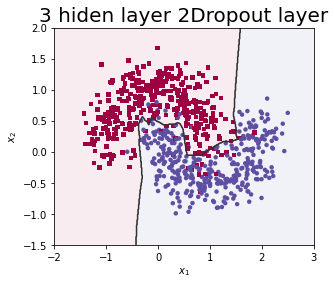

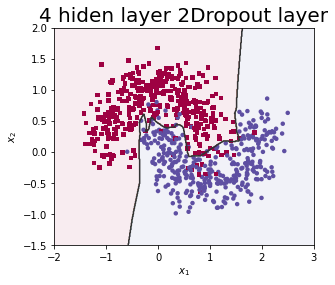

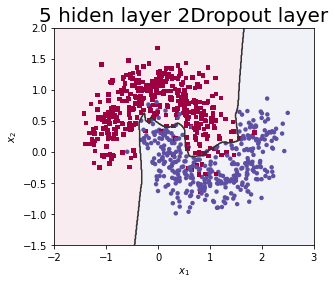

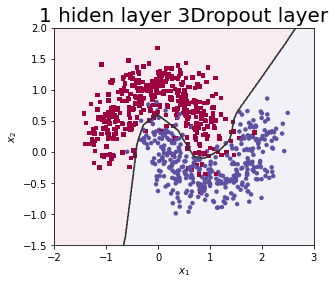

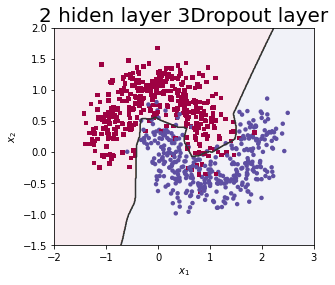

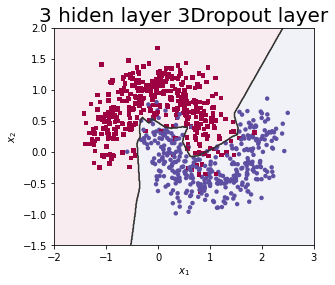

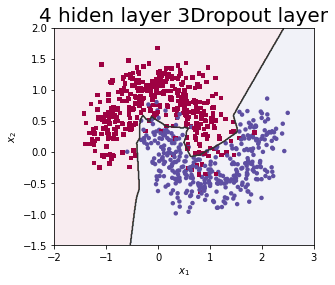

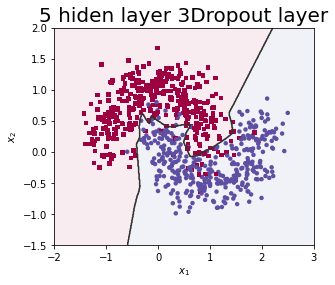

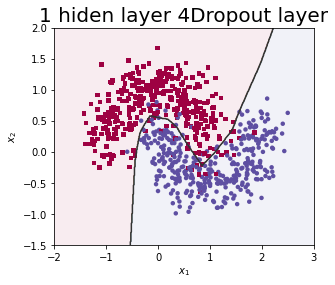

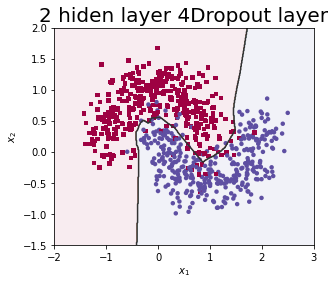

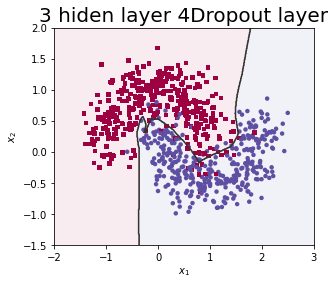

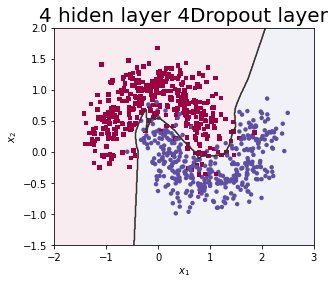

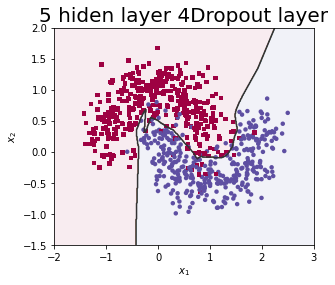

In [42]:
dropout_influence(X_train, y_train)

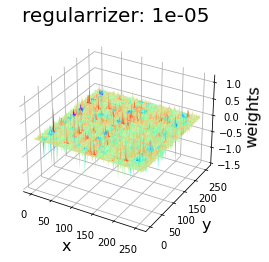

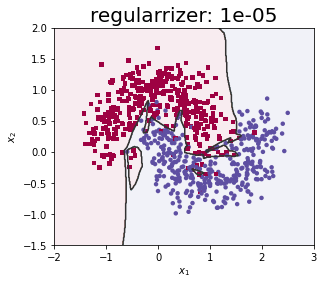

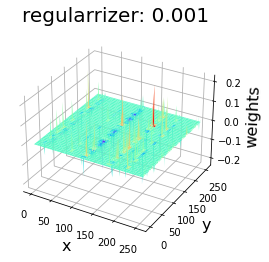

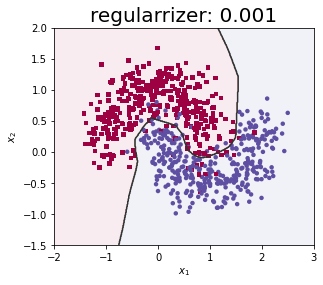

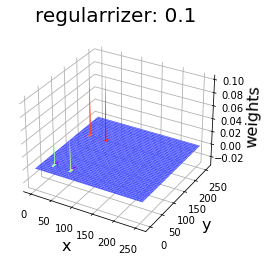

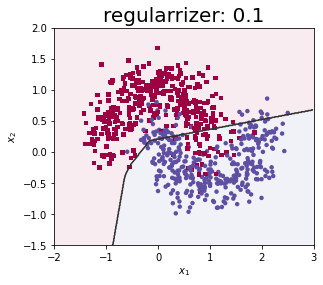

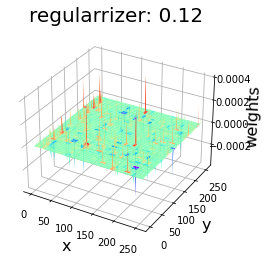

/home/thisischixu/env/tf_py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


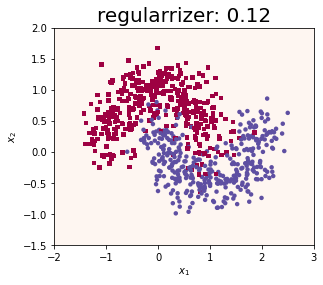

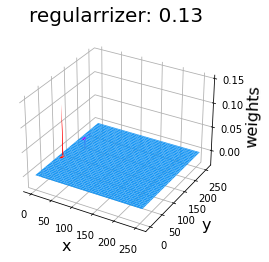

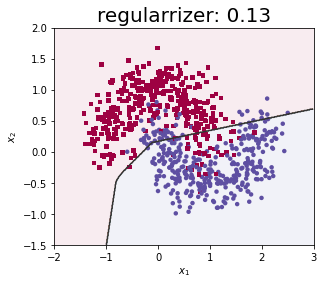

In [61]:
regularizers_influence(X_train, y_train)